# Initializations

In [1]:
from __future__ import division
from IPython.display import Image

import theano
import matplotlib
from theano import tensor as T
from theano import function, pp, shared, printing, d3viz as d3v
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # Use seaborn styles for nice-looking plots

from IPython.core.display import display, HTML  
display(HTML("<style>.container { width:95% !important; }</style>")) #bigger notebook
from IPython.display import SVG

from sklearn.metrics import classification_report, roc_curve, auc

# Add 2 scalars

Let define two symbols (Variables) representing the quantities that you want to add. 

In [6]:
x = T.dscalar('x')
y = T.dscalar('y')

In Theano, all symbols must be typed. In particular, T.dscalar is the type we assign to ''0-dimensional arrays (scalar) of doubles (d)''. It is a Theano Type.  x & y are instances of TensorVariable

In [7]:
print(x.type, y.type)

(TensorType(float64, scalar), TensorType(float64, scalar))


In [8]:
z = x + y

z is yet another Variable which represents the addition of x and y. You can use the pp function to pretty-print out the computation associated to z.

In [9]:
print(pp(z))

(x + y)


In [10]:
f = function(inputs=[x, y], outputs=z)

The first argument to function is a list of <i>Variables</i> that will be provided as inputs to the function.<br>
The second argument is a single Variable or a list of Variables. <br>
For either case, the second argument is what we want to see as output when we apply the function. <br>
<i>f</i> may then be used like a normal Python function.<br>

In [11]:
print f(1, 2) #3
print f(3, 3) #6

3.0
6.0


The output file is available at add_2_scalars.png


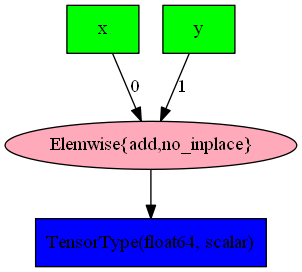

In [12]:
printing.pydotprint(f, outfile='add_2_scalars.png', var_with_name_simple=True)
Image('add_2_scalars.png')

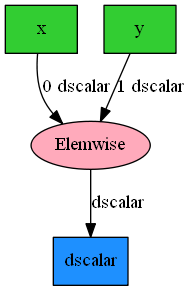

In [13]:
formatter = d3v.formatting.PyDotFormatter()
pydot_graph = formatter(f)

pydot_graph.write_png('add_2_scalars.png');
pydot_graph.write_png('add_2_scalars.pdf');
Image('add_2_scalars.png')

# Add 2 matrices

In [14]:
x = T.dmatrix('x')      # declare variable
y = T.dmatrix('y')
z = x + y               # build symbolic expression
f = function([x, y], z) # compile function

In [15]:
f(np.array([[1, 2], [3, 4]]), 
  np.array([[10, 20], [30, 40]]))

array([[ 11.,  22.],
       [ 33.,  44.]])

# Compute $(x+y)^2$

In [16]:
x = T.dscalar('x')       # declare variable
y = T.dscalar('y')

z = (x+y)**2             # build symbolic expression
f = function([x,y], z)   # compile function

print(pp(z))

((x + y) ** TensorConstant{2})


In [17]:
print(f(1, 1)) # 2
print(f(1.5, 3.5)) # 25

4.0
25.0


# Compute logistic function $s(x) = \frac{1}{1+e^{-x}} $

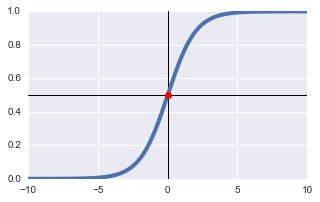

In [18]:
x = np.linspace(-10, 10, 1000)
fig = plt.figure(figsize=(5, 3))
plt.axvline(0, linewidth=1, color='black')
plt.axhline(0.5, linewidth=1, color='black')
plt.plot(x, 1/(1 + np.exp(-x)), linewidth=4)
plt.plot(0, 0.5, 'bo', color='r')
plt.show()

In [19]:
x = T.dmatrix('x')         # declare variable

s = 1 / (1 + T.exp(-x))    # build symbolic expression

logistic = function([x], s) # compile function

a = logistic([[0, 1], [-1, -2]])
print(a)

[[ 0.5         0.73105858]
 [ 0.26894142  0.11920292]]


We know $s(x) = \frac{1}{1+e^{-x}}  = \frac{1+ tanh(x/2)}{2}$, so we can use the second function to see if our computation is correct

In [20]:
s2 = (1 + T.tanh(x / 2)) / 2

logistic2 = function([x], s2)

b = logistic2([[0, 1], [-1, -2]]) 
print(b)

[[ 0.5         0.73105858]
 [ 0.26894142  0.11920292]]


In [21]:
np.allclose(a, b)

True


# Compute more than one thing at the same time

Theano supports functions with multiple outputs. For example, we can compute the elementwise difference, absolute difference, and squared difference between two matrices a and b at the same time:

In [22]:
a, b = T.dmatrices('a', 'b')  # declare variable

diff = a - b                  # build symbolic expression
abs_diff = abs(diff)
diff_squared = diff**2


f = function(inputs=[a, b], outputs=[diff, abs_diff, diff_squared]) # compile function

f([[1, 1], [1, 1]], [[0, 1], [2, 3]])

[array([[ 1.,  0.],
        [-1., -2.]]), array([[ 1.,  0.],
        [ 1.,  2.]]), array([[ 1.,  0.],
        [ 1.,  4.]])]

# Using Shared Variables

It is also possible to make a function with an internal state. For example, let’s say we want to make an accumulator: at the beginning, the state is initialized to zero. Then, on each function call, the state is incremented by the function’s argument.

First let’s define the accumulator function. It adds its argument to the internal state, and returns the old state value.

In [23]:
state = shared(0)

inc = T.iscalar('inc')

accumulator = function(inputs=[inc], outputs=state, updates=[(state, state+inc)])

The shared function constructs so-called <i>shared variables</i>. 

These are hybrid symbolic and non-symbolic variables whose value may be shared between multiple functions. 

Shared variables can be used in symbolic expressions just like the objects returned by dmatrices(...) but they also have an internal value that defines the value taken by this symbolic variable in all the functions that use it. 

It is called a shared variable because its value is shared between many functions. The value can be accessed and modified by the <i>.get_value()</i> and <i>.set_value()</i> methods. 

The other new thing in this code is the <i>updates</i> parameter of function. <i>updates</i> must be supplied with a list of pairs of the form (shared-variable, new expression). It can also be a dictionary whose keys are shared-variables and values are the new expressions. Either way, it means “whenever this function runs, it will replace the .value of each shared variable with the result of the corresponding expression”. Above, our accumulator replaces the state‘s value with the sum of the state and the increment amount.

In [24]:
state.set_value(0)
print(state.get_value())

accumulator(1)
print(state.get_value())

accumulator(300)
print(state.get_value())

0
1
301


In [25]:
state.set_value(-1)
accumulator(3)
print(state.get_value())

2


In [26]:
decrementor = function([inc], state, updates=[(state, state-inc)])

state.set_value(3)
decrementor(2)

print(state.get_value())

1


# Computing Gradients

Let create a function which computes the derivative of some expression y with respect to its parameter x. To do this we will use <i>T.grad</i>. For instance, we can compute the gradient of $x^2$ with respect to $x$. Note that: $d(x^2)/dx = 2 \cdot x$.

In [27]:
x = T.dscalar('x') # declare variable

y = x ** 2         # build symbolic expression

gy = T.grad(y, x)  # gradient expession

f = function(inputs=[x], outputs=gy) # compile function

print(f(4))

np.allclose(f(4), 8.0)

8.0


True

Compute gradient of logistic function

In [28]:
x = T.dmatrix('x')
s = T.sum(1 / (1 + T.exp(-x)))

gs = T.grad(s, x)

dlogistic = function([x], gs) # derivative of logistic function

a = dlogistic([[0, 1], [-1, -2]])
print(a)

[[ 0.25        0.19661193]
 [ 0.19661193  0.10499359]]


Checking gradient using analytic form $df(x)/dx = f(x)*(1-f(x))$

In [29]:
s = 1 / (1 + T.exp(-x))
d = s *(1-s)
dl = function([x], d)

b = dl([[0, 1], [-1, -2]])
print(b)

np.allclose(a, b)

[[ 0.25        0.19661193]
 [ 0.19661193  0.10499359]]


True

# Implement 0-Hidden Layer Neural Network

Digits image classification problem with MNIST dataset. We have digit images with size 28x28 in gray scale. The task is to identify new images.


## Data preparation

Load and divide MNIST data set into train, test sets. <i>X</i> is image, and <i>Y</i> is its label. 
The image size is 28*28, and we flatten it to a 784-dim vector 

### One-hot representation

The label <i>Y</i> is represented in onehot vector. 
A onehot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. 
In this case, the $n^{th}$ digit will be represented as a vector which is 1 in the $n^{th}$ dimensions. 
For example, 0 would be [1,0,0,0,0,0,0,0,0,0,0]. 

In [59]:
def one_hot(x, n):    
    if type(x) == list:
        x = np.array(x)       
    x = x.flatten()
    o_h = np.zeros((len(x), n))
    o_h[np.arange(len(x)), x] = 1
    
    return o_h

### Load MNIST into train & test sets

In [60]:
def load_mnist(ntrain=60000, ntest=10000, onehot=True):
   
    data_dir = 'datasets\\mnist'
    
    fd = open(os.path.join(data_dir, 'train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trX = loaded[16:].reshape((60000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 'train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join(data_dir, 't10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teX = loaded[16:].reshape((10000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 't10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teY = loaded[8:].reshape((10000))

    trX = trX/255.
    teX = teX/255.

    trX = trX[:ntrain]
    trY = trY[:ntrain]

    teX = teX[:ntest]
    teY = teY[:ntest]
    
    if onehot:
        trY = one_hot(trY, 10)
        teY = one_hot(teY, 10)
    else:
        trY = np.asarray(trY)
        teY = np.asarray(teY)

    return trX,teX,trY,teY



trainX, testX, trainY, testY = load_mnist(onehot=True)  #Loading data matrices

### Plot a single data

In [61]:
def plot_single_data(x):
    fig, ax = plt.subplots()
    im = ax.imshow(x.reshape(28,28))
    ax.grid(False)
    fig.colorbar(im)
    plt.show()

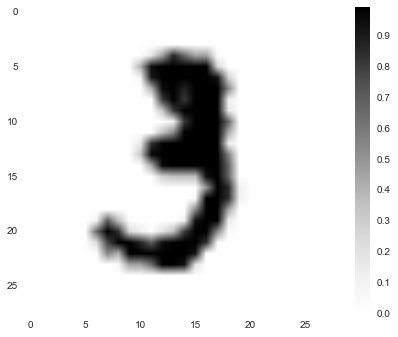

In [62]:
plot_single_data(trainX[10])

## 0-hidden Neural Network

![title](images/0-hidden-layer-NN.png)

### Define maths symbols

In [63]:
def floatX(X):
    """ Conver to correct dtype """
    return np.asarray(X, dtype=T.config.floatX)

def init_weights(shape, var_name):
    """ initalize model parameters """
    return shared(floatX(np.random.randn(*shape) * 0.01), name=var_name)

def init_bias(n_out, var_name):
    """ initialize bias weight as a vector of 0s"""
    return shared(floatX(np.zeros((n_out,))), name=var_name)

In [64]:
X = T.fmatrix("X")  # matrix types variables
Y = T.fmatrix("Y")

w = init_weights((784, 10), 'w')  # initalize weights matrix
b = init_bias(10, 'b') 

### Define model

The softmax function is a generalization of the logistic function. 
It maps a vector of real values to a probability distribution. 
It is widely used for multi-class classification problems. 
In this context, if we are trying to predict the class of an instance out of K possible classes, 
the model would compute a K-dimensional vector whose components represent the confidence scores for each class. 
Then, the softmax function would map those scores to a posterior probability distribution over the possible classes using the following formula:

$$ p(y=j|X) = \frac{e^{X^T. W_j}}{\sum_{k=1}^{K}{e^{X^T.W_k}}} $$

In [65]:
def model(X, w, b):
    """Logistic regresion in matrix format y = softmax(X.w + b)
    """
    return T.nnet.softmax(T.dot(X, w) + b)

In [66]:
py_x = model(X, w, b)  # p(y|x): probability of label given the input
y_pred = T.argmax(py_x, axis=1)  # probality outputs and max predictions

#### Why do we need bias node?
+ the bias is output of the neural net when it has absolutely zero input
+ a bias value allows you to shift the activation function away to the left or right, which may be critical for successful learning.



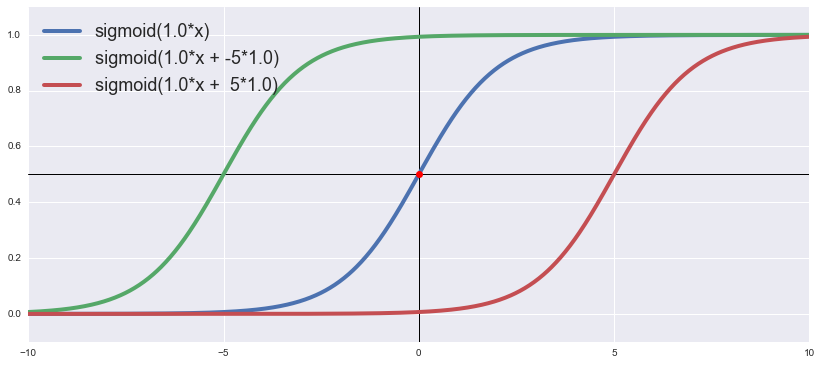

In [67]:
x = np.linspace(-10, 10, 1000)
fig = plt.figure(figsize=(14, 6))
plt.axvline(0, linewidth=1, color='black')
plt.axhline(0.5, linewidth=1, color='black')

plt.plot(x, 1/(1 + np.exp(-x)), linewidth=4, label='sigmoid(1.0*x)')
plt.plot(x, 1/(1 + np.exp(-x + -5*1.0)), linewidth=4, label='sigmoid(1.0*x + -5*1.0)')
plt.plot(x, 1/(1 + np.exp(-x + 5*1.0)), linewidth=4,label= 'sigmoid(1.0*x +  5*1.0)') 

plt.plot(0, 0.5, 'bo', color='r')

plt.ylim(-0.1, 1.1)
plt.legend(loc='best', fontsize='18')
plt.show()


### Define cost function

In order to train our model, we need to define what it means for the model 
to be good. Well, actually, in machine learning we typically define what it 
means for a model to be bad, called the cost or loss, and then try to minimize 
how bad it is. But the two are equivalent.

One very common, very nice cost function is "cross-entropy." Surprisingly, 
cross-entropy arises from thinking about information compressing codes in 
information theory but it winds up being an important idea in lots of areas, 
from gambling to machine learning. It's defined:

\begin{equation*}
H_Y(p(y|x)) = - \sum_i y_i * log(p(y|{x_i}))
\end{equation*}

where Y os the true distribution (the one-hot vector we'll input) $p(y|x)$ is our predicted probability distribution
In some rough sense, the cross-entropy is measuring how inefficient our 
predictions are for describing the truth.   

In [68]:
cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))

### Define gradient & weight update functions

In [69]:
gradient_w = T.grad(cost=cost, wrt=w)  # Compute gradient for weights w
gradient_b = T.grad(cost=cost, wrt=b)  # Compute gradient for bias b

learning_rate = 0.05
update = [(w, w - gradient_w * learning_rate), 
          (b, b - gradient_b * learning_rate)]  # Weight update with gradient descent


### Compile traing & predict functions

In [70]:
# compile train function
train = function(inputs=[X, Y], 
                 outputs=cost, 
                 updates=update, 
                 allow_input_downcast=True)

# compile prediction function
predict = function(inputs=[X], 
                   outputs=y_pred, 
                   allow_input_downcast=True)

### Perform training

Epoch: 0 ; Accuracy: 0.879
Epoch: 1 ; Accuracy: 0.891
Epoch: 2 ; Accuracy: 0.899
Epoch: 3 ; Accuracy: 0.903
Epoch: 4 ; Accuracy: 0.907
Epoch: 5 ; Accuracy: 0.909
Epoch: 6 ; Accuracy: 0.910
Epoch: 7 ; Accuracy: 0.912
Epoch: 8 ; Accuracy: 0.913
Epoch: 9 ; Accuracy: 0.914


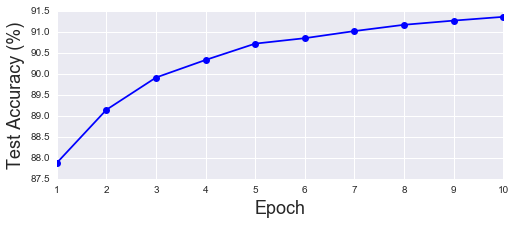

In [71]:
# run training with 10 epochs and on mini-batches of 200 examples
epoch = 10
batch_size = 200

acc = []
for i in range(epoch):
    for start, end in zip(range(0, len(trainX), batch_size), range(batch_size, len(trainX), batch_size)):
        cost = train(trainX[start:end], trainY[start:end])
    
    
    acc.append(100*np.mean(np.argmax(testY, axis=1) == predict(testX)))
    print('Epoch: %d ; Accuracy: %.3f' % (i, np.mean(np.argmax(testY, axis=1) == predict(testX))))

    
#plot test accuracy vs. training epochs    
fig = plt.figure(figsize=(8, 3))
plt.plot(np.arange(1,11), acc, 'bo-')
plt.xlabel('Epoch', fontsize='18')
plt.ylabel('Test Accuracy (%)', fontsize='18')
plt.show()

### Analyzing model

Softmax [id A] ''   
 |Elemwise{add,no_inplace} [id B] ''   
   |dot [id C] ''   
   | |X [id D]
   | |w [id E]
   |DimShuffle{x,0} [id F] ''   
     |b [id G]


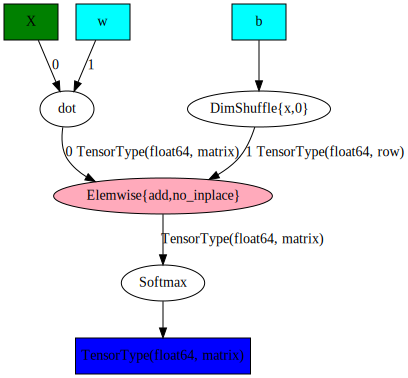

In [134]:
# computation graph
printing.debugprint(py_x)
SVG(theano.printing.pydotprint(py_x, var_with_name_simple=True, return_image=True, format='svg')) # need to install GraphViz & pydot

In [128]:
def analyze_net(w_o, img_dim):    
    """ What does the softmax learn? """
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)   

    a = np.array(w_o.get_value())  
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(40, 15))
    for i, ax in enumerate(axes.flat):
        ax.set_title(str(i), fontsize=50)
        im = ax.imshow(a[:,i].reshape(img_dim, img_dim), interpolation='none')
        ax.grid(False)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

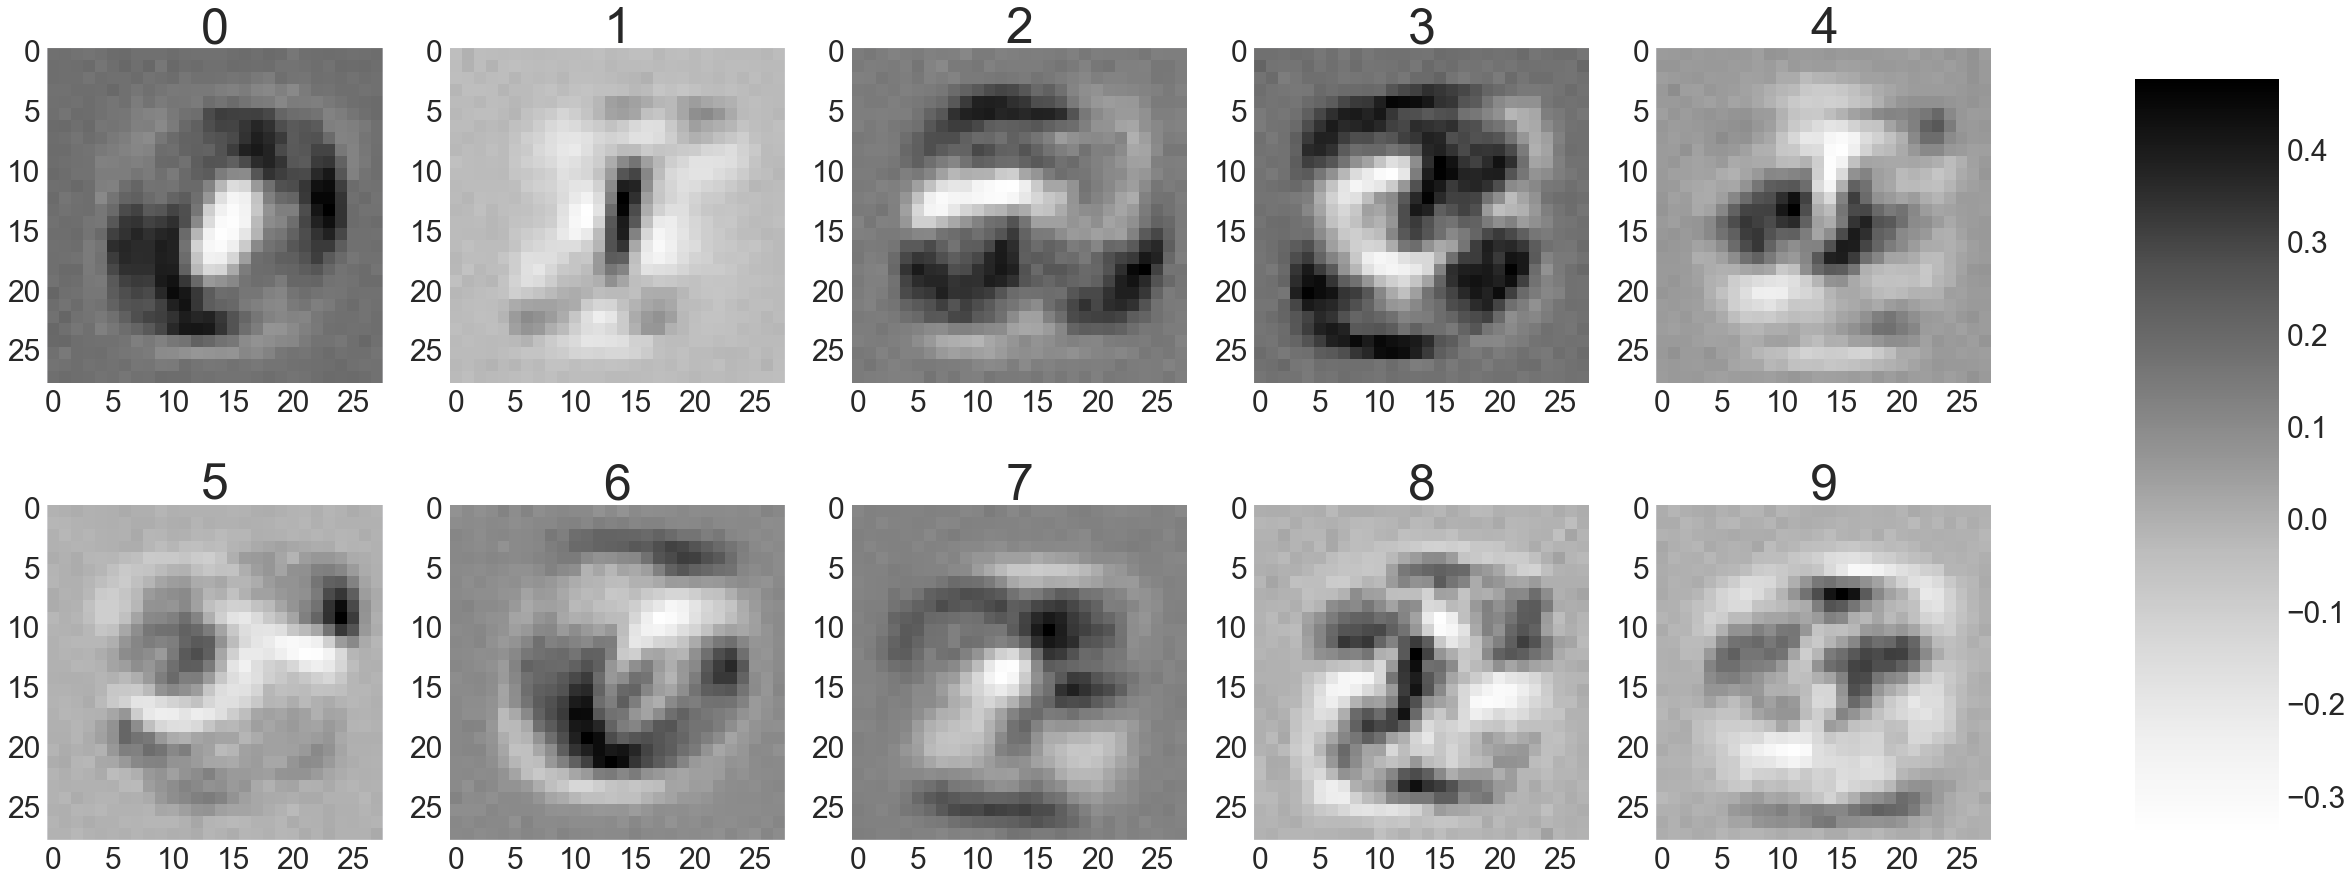

In [133]:
# weight visualization
analyze_net(w, 28)